In [1]:
name_of_experiment = "500_raw_rel"
output_file = "eval.json"

In [32]:
# Посчитать метрики
from documents import FileSystem
import asyncio
from pathlib import Path
import json
from lexis import extract_number
import numpy as np


async def eval(name_of_file_to_save: str | Path, name_of_experiment: str | Path):
    base_path = Path("data") / "eval"

    eval_dict = {
        "all_docs": 0,
        "self_top1": 0,
        "soft": 0,
        "hard": 0,
        "avg": 0,
        "no_relevant": 0,
    }

    with open(
        next((base_path / name_of_experiment).iterdir()), encoding="utf-8"
    ) as file:
        methods = list(json.load(file)["relevant"].keys())

    metrics = {method: eval_dict.copy() for method in methods}

    list_of_files = list((base_path / name_of_experiment).iterdir())

    for file_path in list_of_files:
        doc_id = extract_number(file_path.stem)

        with open(file_path, encoding="utf-8") as file:
            data = json.load(file)

        citations = list(map(extract_number, data["56"]))
        cluster = list(map(extract_number, data["cluster"]))

        evaluate_data = set(citations)
        # evaluate_data = set(citations + cluster)

        evaluate_data = evaluate_data - set([doc_id])

        for extractor_name, relevant_docs in data["relevant"].items():
            # if extractor_name not in metrics.keys():
            #     continue

            relevant = list(dict.fromkeys(map(extract_number, relevant_docs)))

            if relevant:

                if doc_id in relevant:
                    metrics[extractor_name]["self_top1"] += relevant[0] == doc_id
                    relevant.remove(doc_id)
            else:
                metrics[extractor_name]["no_relevant"] += 1

            relevant = relevant[:20]

            if len(evaluate_data) > 0:
                num_of_hits = 0
                for doc in evaluate_data:
                    if doc in relevant:
                        num_of_hits += 1

                metrics[extractor_name]["soft"] += num_of_hits > 0
                metrics[extractor_name]["avg"] += num_of_hits / len(evaluate_data)
                metrics[extractor_name]["hard"] += num_of_hits == len(evaluate_data)
                metrics[extractor_name]["all_docs"] += 1

    for extractor_name, eval in metrics.items():
        print(extractor_name, "metrics:")
        for metric in eval.keys():
            if metric in ["self_top1", "no_relevant"]:
                eval[metric] = round(eval[metric] / len(list_of_files), 2)
            elif metric not in ["all_docs"]:
                eval[metric] = round(eval[metric] / eval["all_docs"], 4)

            if metric not in ["avg", "soft", "hard"]:
                print(metric, "-", round(eval[metric], 4))
        print()

    with open(base_path / name_of_file_to_save, "w+") as file:
        json.dump(metrics, file, ensure_ascii=False, indent=4)


if name_of_experiment is None:
    name_of_experiment = "80_rel"
if output_file is None:
    output_file = "eval.json"

await eval(output_file, name_of_experiment)
print("Метрики посчитаны")

YAKE metrics:
all_docs - 378
self_top1 - 0.92
no_relevant - 0.01

multilingual-mpnet metrics:
all_docs - 378
self_top1 - 0.74
no_relevant - 0.0

e5-large metrics:
all_docs - 378
self_top1 - 0.94
no_relevant - 0.0

iteco metrics:
all_docs - 378
self_top1 - 0.83
no_relevant - 0.07

Метрики посчитаны


,YAKE,multilingual-mpnet,e5-large,iteco
all_docs,378.0000,378.0000,378.0000,378.0000
self_top1,0.9200,0.7400,0.9400,0.8300
soft,0.2804,0.0476,0.2381,0.2275
hard,0.0212,0.0026,0.0132,0.0159
avg,0.1083,0.0174,0.0904,0.0895
no_relevant,0.0100,0.0000,0.0000,0.0700


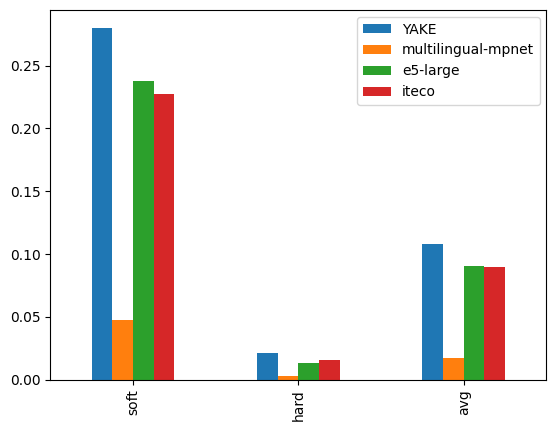

In [33]:
# Вывести метрики по разным моделям
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt


BASE_PATH = Path("data") / "eval"

with open(BASE_PATH / output_file) as file:
    rawdata = json.load(file)
data = {i: {} for i in rawdata.keys()}
for k, v in rawdata.items():
    for k1, v1 in v.items():
        if k1 not in ["all_docs", "self_top1", "no_relevant"]:
            data[k][k1] = v1

data = pd.DataFrame(data)

data.plot.bar()
pd.DataFrame(rawdata)

In [ ]:
# Разделить метрики по виду экстрактора

from pathlib import Path

import pandas as pd
from sklearn import metrics
import json
import matplotlib.pyplot as plt


base_path = Path("data") / "eval"
with open(base_path / "eval.json", encoding="utf-8") as file:
    rawdata = json.load(file)

metrics = ["soft", "hard", "avg"]

yake = {
    k: {k1: v1 for k1, v1 in v.items() if k1 in metrics}
    for k, v in rawdata.items()
    if "YAKE" in k
}
e5 = {
    k: {k1: v1 for k1, v1 in v.items() if k1 in metrics}
    for k, v in rawdata.items()
    if "e5" in k
}
mpnet = {
    k: {k1: v1 for k1, v1 in v.items() if k1 in metrics}
    for k, v in rawdata.items()
    if "mpnet" in k
}

methods = ["expand", "mix", "shuffle", "raw"]


data = yake

data_dict = {}
for method in methods:
    data_dict[method] = {k: v for k, v in data.items() if method in k}


exp = pd.DataFrame(data_dict["expand"])
mix = pd.DataFrame(data_dict["mix"])
shuf = pd.DataFrame(data_dict["shuffle"])
raw = pd.DataFrame(data_dict["raw"])


exp.plot.bar()
mix.plot.bar()
shuf.plot.bar()
raw.plot.bar()

,75,100,125,150,175,200
soft,0.400000,0.369792,0.381250,0.388542,0.394792,0.396875
hard,0.077083,0.071875,0.090625,0.091667,0.090625,0.084375
avg,0.212733,0.197142,0.212025,0.220517,0.225183,0.221958


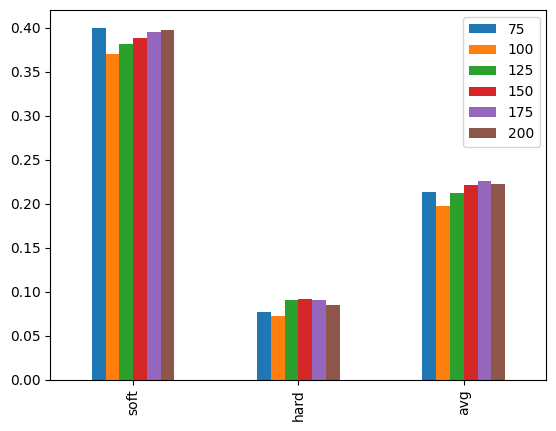

In [37]:
# Усредненные по длинам метрики


import numpy as np

nums = [75, 100, 125, 150, 175, 200]


data = {str(num): {m: list() for m in metrics} for num in nums}

method = "mpnet"

for k, v in rawdata.items():
    num = k.split("_")[-1]
    # if method not in k:
    #     continue

    for k1, v1 in v.items():
        if k1 in metrics:
            data[num][k1].append(v1)

for k, v in data.items():
    for k1 in v.keys():
        v[k1] = np.mean(v[k1])

data = pd.DataFrame(data)

data.plot.bar()
data

In [36]:
# Сравнить готовые терм вектора с полученными моей системой

from pathlib import Path
from lexis import lemmatize_ru_word
from documents import FileSystem
import pandas as pd
import json

BASE_PATH = Path("data") / "eval"
name_of_experiment = "80"
# old_docs = old system termvectors (keywords)

old_docs = {}

with open(Path("data") / "raw" / "term_vectors.json", encoding="utf-8") as file:
    raw_data = json.load(file)

for i in raw_data:
    # id_mass = raw["Документ"].split("_")
    id = i["doc_id"]

    old_docs[id] = []
    tv = i["termvector"][0]
    for t in tv.split(" "):
        word = t.split("~")[0]
        old_docs[id].append(lemmatize_ru_word(word))

# new_docs = my keywords

new_docs = {}

list_of_files = list((BASE_PATH / "500").iterdir())

for file_path in list_of_files:
    with open(file_path, encoding="utf-8") as file:
        data = json.load(file)
    new_docs[file_path.stem] = {
        extractor_name: list(map(lemmatize_ru_word, kws[0]))
        for extractor_name, kws in data["keywords"].items()
    }

# evaluation dicts

eval_dict = {
    "all_docs": 0,
    "same_top1": 0,
    "soft": 0,
    "hard": 0,
    "avg": 0,
    "no_match": 0,
}

with open(
    BASE_PATH / (name_of_experiment + "_performance.json"), encoding="utf-8"
) as file:
    performance = json.load(file)


metrics = {method: eval_dict.copy() for method in performance.keys()}

# evaluation
# bebra = []
for new_doc_id, new_kws in new_docs.items():
    try:
        old_kw = old_docs[new_doc_id]
        for extractor_name, new_kw in new_kws.items():
            hits = 0
            for new_term in new_kw:
                if new_term in old_kw:
                    hits += 1
                # if "cls" in new_term.lower():
                #     bebra.append(new_term)

            metrics[extractor_name]["same_top1"] += new_kw[0] == old_kw[0]
            metrics[extractor_name]["soft"] += hits > 0
            metrics[extractor_name]["avg"] += hits / len(old_kw)
            metrics[extractor_name]["hard"] += hits == len(old_kw)
            metrics[extractor_name]["no_match"] += hits == 0
            metrics[extractor_name]["all_docs"] += 1

    except KeyError:
        continue

for extractor_name, eval in metrics.items():
    # print(extractor_name, "metrics:")
    for metric in eval.keys():
        if metric != "all_docs":
            eval[metric] = round(eval[metric] / eval["all_docs"], 2)

print("Метрики посчитаны")
data = pd.DataFrame(metrics)
data
# print(len(bebra), bebra)

Метрики посчитаны


,YAKE,multilingual-mpnet,e5-large
all_docs,500.00,500.00,500.00
same_top1,0.13,0.06,0.12
soft,1.00,0.91,0.99
hard,0.00,0.00,0.00
avg,0.41,0.06,0.17
no_match,0.00,0.09,0.01


In [ ]:
# Оценить скорость работы алгоритмов

from documents import FileSystem
import numpy as np

# doc_dict = {doc.id async for doc in FileSystem("data\\raw\\skolkovo")}

for extractor_name, value_dict in performance.items():
    # TODO: Дописать + нарисовать графики
    print(f"Среднее время - {np.mean(value_dict["time"])}сек (общее) {1}симв/сек")

In [35]:
# Количество таймаутов
from pathlib import Path
import json


base_path = Path("data") / "eval" / "80_rel_2"

paths = list(base_path.iterdir())

count = 0
empty = 0
for path in paths:
    with open(path, encoding="utf-8") as file:
        data = json.load(file)
    relevant = data["relevant"]
    for v in relevant.values():
        count += 1
        if not v:
            empty += 1

print(empty, count)

226 4896


In [2]:
# Добавить iteco векторы к имеющимся

from pathlib import Path
from lexis import lemmatize_ru_word
from documents import FileSystem
import pandas as pd
import json
import re
from chain import save_data_to_json, load_data_from_json

BASE_PATH = Path("data") / "eval"
name_of_experiment = "500_raw_rel"
# old_docs = old system termvectors (keywords)

old_docs = {}

with open(Path("data") / "raw" / "term_vectors.json", encoding="utf-8") as file:
    raw_data = json.load(file)

for i in raw_data:
    # id_mass = raw["Документ"].split("_")
    id = i["doc_id"]

    old_docs[id] = []
    tv = i["termvector"][0]
    for t in tv.split(" "):
        word = t.split("~")[0]
        old_docs[id].append(lemmatize_ru_word(word))


path = BASE_PATH / name_of_experiment

for i in path.iterdir():
    doc_id = i.stem

    termvector = old_docs[doc_id]
    termvector = list(
        map(lambda x: "".join(re.findall(r"[А-Яа-яA-Za-z0-9-]+", x)), termvector)
    )

    data = await load_data_from_json(i)
    data["keywords"]["iteco"] = [termvector]
    # del data["keywords"]["iteco"]
    await save_data_to_json(data, i)

In [120]:
# Обнулить поисковую выдачу по конкретному методу

from pathlib import Path
from lexis import lemmatize_ru_word
from documents import FileSystem
import pandas as pd
import json
import re
from chain import save_data_to_json, load_data_from_json

methods_to_nullify = ["iteco"]

BASE_PATH = Path("data") / "eval"
name_of_experiment = "500_raw_rel"

path = BASE_PATH / name_of_experiment

for i in path.iterdir():
    doc_id = i.stem
    data = await load_data_from_json(i)

    for method in methods_to_nullify:
        data["relevant"][method] = []

    await save_data_to_json(data, i)